In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import glob as gb
import os
import matplotlib.dates as mdates

%matplotlib notebook

# Experiment Info

* 1600nm laser at 0.07A
* Laser on for 50 ms and off for 150ms (25% duty cycle)
* Capturing 50ms of data on rising edge trigger of laser at 10kHz. Data points are then averaged. This is reppeateded over the entire time during which the experiment is on.
* Two syringe pumps flow at different ratios (summing to 1ml/min) into a Y and then an epoxy mixer nozzel before going into the flow cell (horizontal)

# 0 to 10 % Intralipid data

In [3]:
# Load data
df = pd.HDFStore('../Data/IL_reflection_1600nm_0to20percent/IL_0_10.h5')['df']

In [4]:
# Create time into experiment axis
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

In [6]:
# Get flush time for each concentration (used for plotting later)
try:
    flush_time = df['run_time'][0]
    print(flush_time)
except KeyError:
    print('Not valid entry')

10


In [7]:
# Drop first sweeps (300 sweeps = 1 min @ 5HZ capture rate)
df = df[df.sweep_no > 1200]

In [8]:
# Group all data by concentration
grouped = df.groupby(['concentration'])

<IPython.core.display.Javascript object>


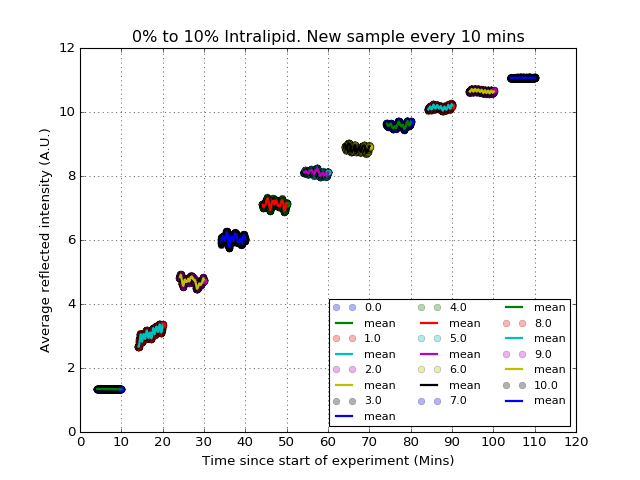

In [9]:
# Plot
fig, ax = plt.subplots()

for key, group in grouped:
    ax.plot(group['delta'], group['mean'], 'o', alpha=0.3, label=key)
    rolling = group['mean'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2)  # label='rolling ({k})'.format(k=key)

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
plt.xticks(np.arange(0, max(group['delta'])+flush_time, flush_time))
# fig.autofmt_xdate()  # Rotate slightly

plt.legend(loc='best', ncol=3, fontsize='small')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Average reflected intensity (A.U.)')
plt.title('0% to 10% Intralipid. New sample every {:d} mins'.format(flush_time))

In [10]:
# Apply mean and std functions to each concentration
g1 = grouped.agg([np.mean, np.std])

# 20 - 8% Intralipid data

In [13]:
# Load data
df = pd.HDFStore('../Data/IL_reflection_1600nm_0to20percent/IL_20_7.h5')['df']

In [14]:
# Create time into experiment axis
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

In [15]:
# Get flush time for each concentration (used for plotting later)
try:
    flush_time = df['run_time'][0]
    print(flush_time)
except KeyError:
    print('Not valid entry')

5


In [16]:
# Drop first sweeps (300 sweeps = 1 min @ 5HZ capture rate)
df = df[df.sweep_no > 900]

In [17]:
# Group all data by concentration
grouped = df.groupby(['concentration'])

<IPython.core.display.Javascript object>


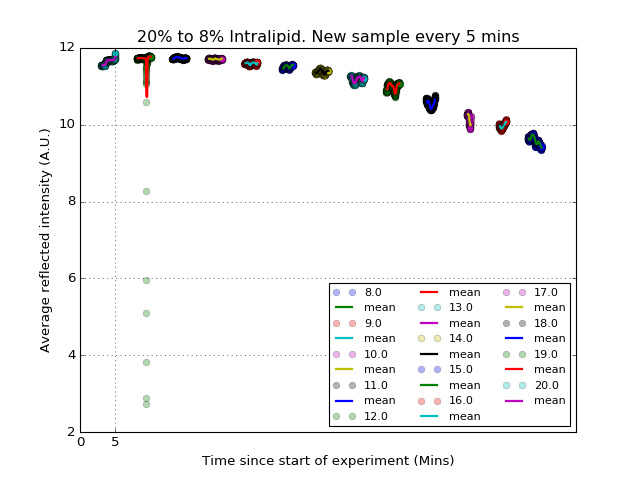

In [18]:
# Plot
fig, ax = plt.subplots()

for key, group in grouped:
    ax.plot(group['delta'], group['mean'], 'o', alpha=0.3, label=key)
    rolling = group['mean'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2)  # label='rolling ({k})'.format(k=key)

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
plt.xticks(np.arange(0, max(group['delta'])+flush_time, flush_time))
# fig.autofmt_xdate()  # Rotate slightly

plt.legend(loc='best', ncol=3, fontsize='small')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Average reflected intensity (A.U.)')
plt.title('20% to 8% Intralipid. New sample every {:d} mins'.format(flush_time))

First two runs (20% and 19%) we had problems with IL flowing into water syringe. We had to change syringes during measurements. Only the very last few sweeps will be reliable and so we shall drop the first 1470 sweeps during which time the concentration was the least stable.

In [19]:
df = df[((df.concentration == 19) & (df.sweep_no >= 1470)) | (df.concentration != 19)]
df = df[((df.concentration == 20) & (df.sweep_no >= 1470)) | (df.concentration != 20)]

In [20]:
# Re-group all data by concentration
grouped = df.groupby(['concentration'])

<IPython.core.display.Javascript object>


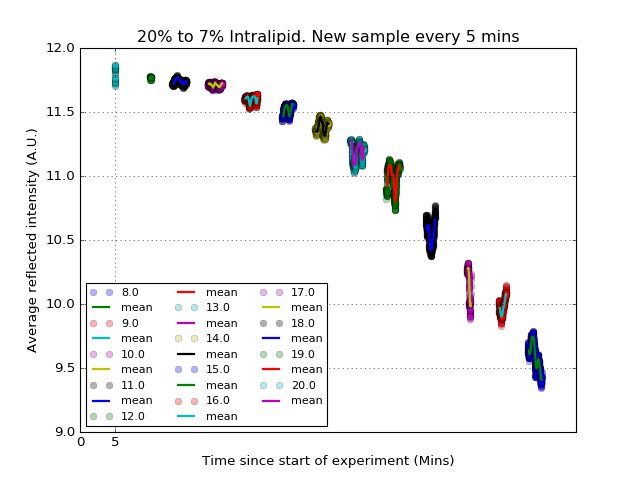

In [21]:
# Re-Plot
fig, ax = plt.subplots()

for key, group in grouped:
    ax.plot(group['delta'], group['mean'], 'o', alpha=0.3, label=key)
    rolling = group['mean'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2)  # label='rolling ({k})'.format(k=key)

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
plt.xticks(np.arange(0, max(group['delta'])+flush_time, flush_time))
# fig.autofmt_xdate()  # Rotate slightly

plt.legend(loc='best', ncol=3, fontsize='small')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Average reflected intensity (A.U.)')
plt.title('20% to 7% Intralipid. New sample every {:d} mins'.format(flush_time))

In [24]:
# Apply mean and std functions to each concentration
g2 = grouped.agg([np.mean, np.std])

In [25]:
# Close all open figures
plt.close("all")

# Join two datasets

In [26]:
# Join and plot
g = pd.concat([g1, g2])
g = g.reset_index()
g = g[['concentration', 'mean']]

<IPython.core.display.Javascript object>


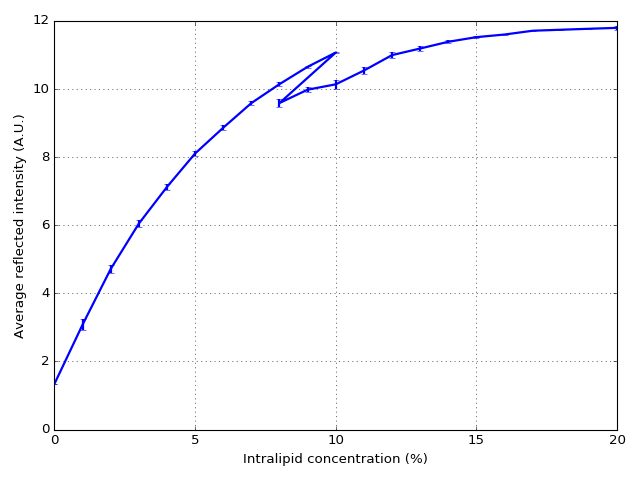

In [27]:
fig, ax = plt.subplots()

ax.errorbar(g['concentration'], g['mean']['mean'], yerr=g['mean']['std'], color='b', lw='2')

ax.set_xlabel('Intralipid concentration (%)')
ax.set_ylabel('Average reflected intensity (A.U.)')

ax.grid()
# plt.tight_layout()
ax.ticklabel_format(useOffset=False, axis='y')

plt.tight_layout()

There is a clear offset between the two data sets. This could be due to either a change in the intralipid sample used or a difference in laser power due to the difference in days the experiments were performed. We will estimate the offset from the data at 8, 9 and 10% concentrations.

In [28]:
# Difference between concentrations 8-10
diff = g1[8:10]['mean'] - g2[8:10]['mean']
diff

,mean,std
concentration,,
8.0,0.55536,-0.054522
9.0,0.67136,-0.028160
10.0,0.93275,-0.129121


In [29]:
# Average offset
offset = diff.mean()['mean']
offset

0.7198232240130954

In [30]:
# Add offset to 7 - 20% data
# Apply offset
df['mean'] = df['mean'].apply(lambda x: x + offset)

# Re-group all data by concentration
grouped = df.groupby(['concentration'])

# Apply mean and std functions to each concentration
g2 = grouped.agg([np.mean, np.std])

In [31]:
# Join and plot
g = pd.concat([g1, g2])
g = g.reset_index()
g = g[['concentration', 'mean']]

In [32]:
g = g.groupby(g.concentration).mean()
g = g['mean']

<IPython.core.display.Javascript object>


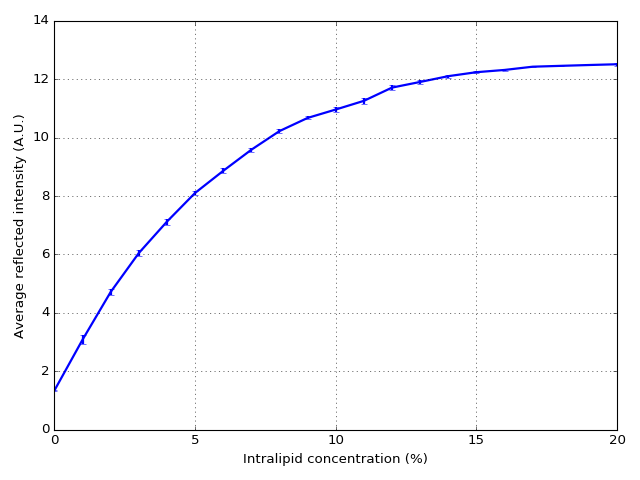

In [33]:
g = g.reset_index()

fig, ax = plt.subplots()

ax.errorbar(g['concentration'], g['mean'], yerr=g['std'], color='b', lw='2')

ax.set_xlabel('Intralipid concentration (%)')
ax.set_ylabel('Average reflected intensity (A.U.)')

ax.grid()
# plt.tight_layout()
ax.ticklabel_format(useOffset=False, axis='y')

plt.tight_layout()

<IPython.core.display.Javascript object>


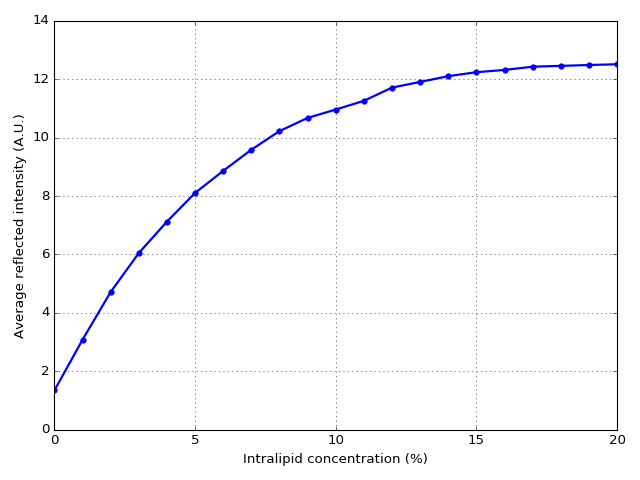

In [39]:
# Plot with no error bars
fig, ax = plt.subplots()

ax.plot(g['concentration'], g['mean'], '.-', color='b', lw='2', markersize='10')

ax.set_xlabel('Intralipid concentration (%)')
ax.set_ylabel('Average reflected intensity (A.U.)')

ax.grid()
# plt.tight_layout()
ax.ticklabel_format(useOffset=False, axis='y')

plt.tight_layout()
plt.savefig('intralipid_reflection_1600nm.png', dpi=900)